
# # Prévision de Consommation CVAC - Implémentation avec Algorithmes ML Classiques

# ## 1. Installation et importation des bibliothèques

In [1]:
# Importation des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold, TimeSeriesSplit
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import joblib
import os
import time
import warnings
import datetime

# Ignorer les avertissements
warnings.filterwarnings('ignore')

# Définir les styles de plot
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

# Fixer la graine aléatoire pour la reproductibilité
np.random.seed(42)




In [3]:

# ## 2. Chargement et exploration des données
# Fonction pour charger les données
def load_and_preprocess_data(train_path, test_path):
    """
    Charge et prétraite les données d'entraînement et de test
    """
    print("Chargement des données...")
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    
    # Conversion des dates
    train_df['date'] = pd.to_datetime(train_df['date'])
    test_df['date'] = pd.to_datetime(test_df['date'])
    
    # Informations de base
    print(f"Dimensions des données d'entraînement: {train_df.shape}")
    print(f"Dimensions des données de test: {test_df.shape}")
    
    # Vérification des valeurs manquantes
    train_missing = train_df.isnull().sum().sum()
    test_missing = test_df.isnull().sum().sum()
    print(f"Valeurs manquantes (train): {train_missing}, (test): {test_missing}")
    
    # Gestion du format de la colonne cible si nécessaire
    if 'puissance_cvac_future' in train_df.columns:
        if train_df['puissance_cvac_future'].dtype == object:
            try:
                train_df['puissance_cvac_future'] = pd.to_numeric(train_df['puissance_cvac_future'], errors='coerce')
            except:
                print("Conversion de la cible en format numérique...")
                train_df['puissance_cvac_future'] = train_df['puissance_cvac_future'].apply(
                    lambda x: np.array(eval(x)) if isinstance(x, str) else x
                )
    
    return train_df, test_df

# Charger les données
train_df = pd.read_csv('train_dataset.csv')
test_df = pd.read_csv('test_features.csv')

# Conversion des dates
train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])

# Informations de base
print(f"Dimensions des données d'entraînement: {train_df.shape}")
print(f"Dimensions des données de test: {test_df.shape}")

# Vérification des valeurs manquantes
train_missing = train_df.isnull().sum().sum()
test_missing = test_df.isnull().sum().sum()
print(f"Valeurs manquantes (train): {train_missing}, (test): {test_missing}")

# Afficher les premières lignes
train_df.head()

Dimensions des données d'entraînement: (35040, 10)
Dimensions des données de test: (35024, 8)
Valeurs manquantes (train): 0, (test): 0


,ID,date,temperature_exterieure,humidite,ensoleillement,vitesse_vent,direction_vent,temperature_interieure,puissance_cvac,puissance_cvac_future
0,0,2022-01-01 00:00:00,3.25,82.0,0.0,6.4,210.0,21.051795,0.874277,1.37769327424343
1,1,2022-01-01 00:15:00,1.50,83.0,0.0,4.6,220.0,20.999963,0.879458,1.38822323802964
2,2,2022-01-01 00:30:00,-0.25,84.0,0.0,2.8,230.0,21.000107,0.946028,1.43538119124427
3,3,2022-01-01 00:45:00,-2.00,85.0,0.0,1.0,240.0,21.000071,1.067489,1.47795172385858
4,4,2022-01-01 01:00:00,-1.95,85.0,0.0,1.0,242.5,21.000084,1.127481,1.48378707175543


In [4]:
# Afficher les premières lignes des données de test
test_df.head()

,ID,date,temperature_exterieure,humidite,ensoleillement,vitesse_vent,direction_vent,temperature_interieure
0,0,2022-01-01 00:00:00,-11.50,69.5,0.0,4.775,260.0,20.989188
1,1,2022-01-01 00:15:00,-8.00,77.0,0.0,6.450,260.0,21.000051
2,2,2022-01-01 00:30:00,-4.50,84.5,0.0,8.125,260.0,21.000019
3,3,2022-01-01 00:45:00,-1.00,92.0,0.0,9.800,260.0,21.000015
4,4,2022-01-01 01:00:00,-1.25,88.5,0.0,9.800,262.5,20.999918


In [5]:


# Statistiques descriptives
train_df.describe()


# ## 3. Analyse exploratoire des données

,ID,date,temperature_exterieure,humidite,ensoleillement,vitesse_vent,direction_vent,temperature_interieure,puissance_cvac
count,35040.000000,35040,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000
mean,17519.500000,2022-07-02 11:52:30,7.924304,67.386287,167.193037,4.538028,187.204481,21.812297,1.529627
min,0.000000,2022-01-01 00:00:00,-23.000000,17.000000,0.000000,0.000000,0.000000,20.506609,0.000000
25%,8759.750000,2022-04-02 05:56:15,-1.000000,55.000000,0.000000,2.725000,102.000000,20.999951,0.251010
50%,17519.500000,2022-07-02 11:52:30,9.000000,68.000000,0.000000,4.100000,220.000000,21.002978,0.777715
75%,26279.250000,2022-10-01 17:48:45,18.000000,81.000000,251.562500,6.000000,265.000000,22.999749,1.881776
max,35039.000000,2022-12-31 23:45:00,33.000000,100.000000,978.000000,21.600000,359.500000,26.010427,10.184208
std,10115.321053,NaN,11.855826,16.626531,272.016185,2.477155,99.617528,0.962409,1.945118


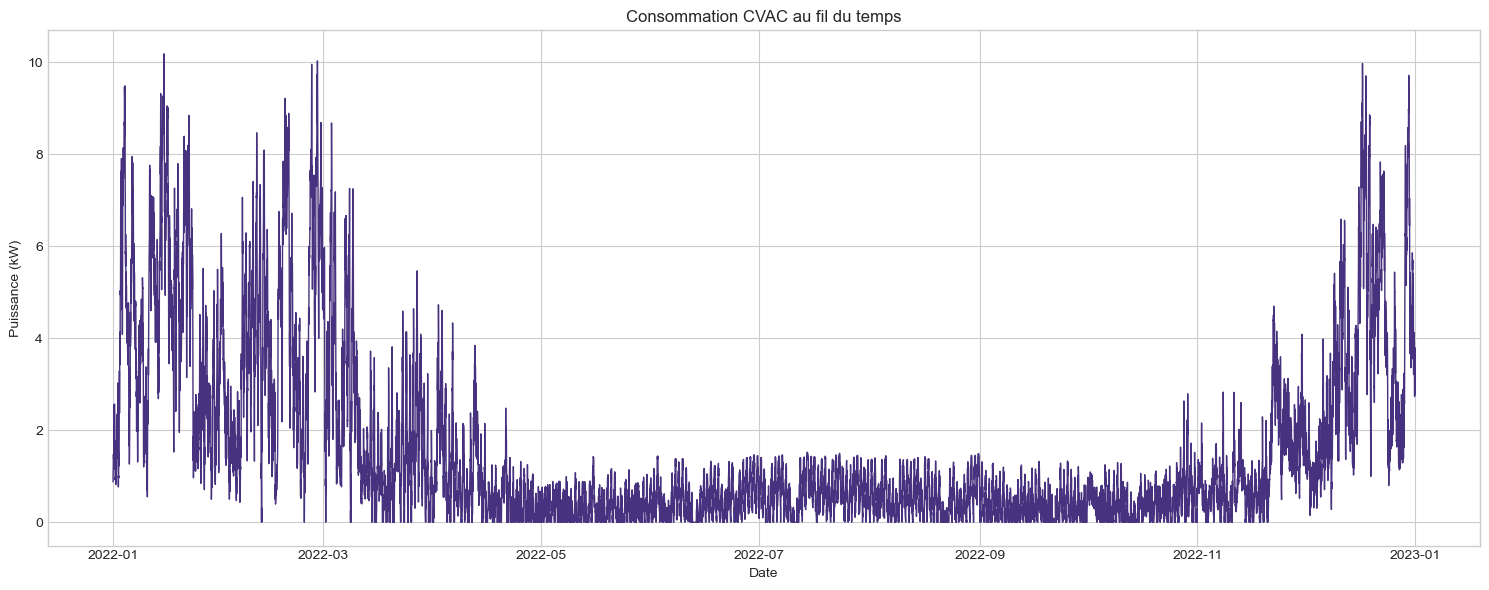

In [6]:


# Visualisation de la puissance CVAC au fil du temps
plt.figure(figsize=(15, 6))
plt.plot(train_df['date'], train_df['puissance_cvac'], linewidth=1)
plt.title('Consommation CVAC au fil du temps')
plt.xlabel('Date')
plt.ylabel('Puissance (kW)')
plt.grid(True)
plt.tight_layout()
plt.show()

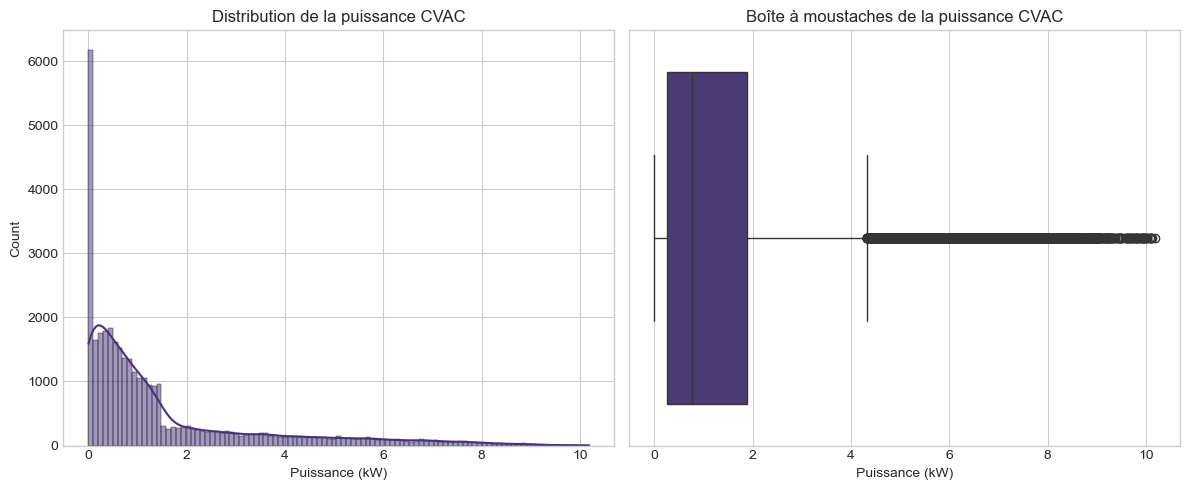

In [7]:


# Distribution de la puissance CVAC
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(train_df['puissance_cvac'], kde=True)
plt.title('Distribution de la puissance CVAC')
plt.xlabel('Puissance (kW)')

plt.subplot(1, 2, 2)
sns.boxplot(x=train_df['puissance_cvac'])
plt.title('Boîte à moustaches de la puissance CVAC')
plt.xlabel('Puissance (kW)')

plt.tight_layout()
plt.show()

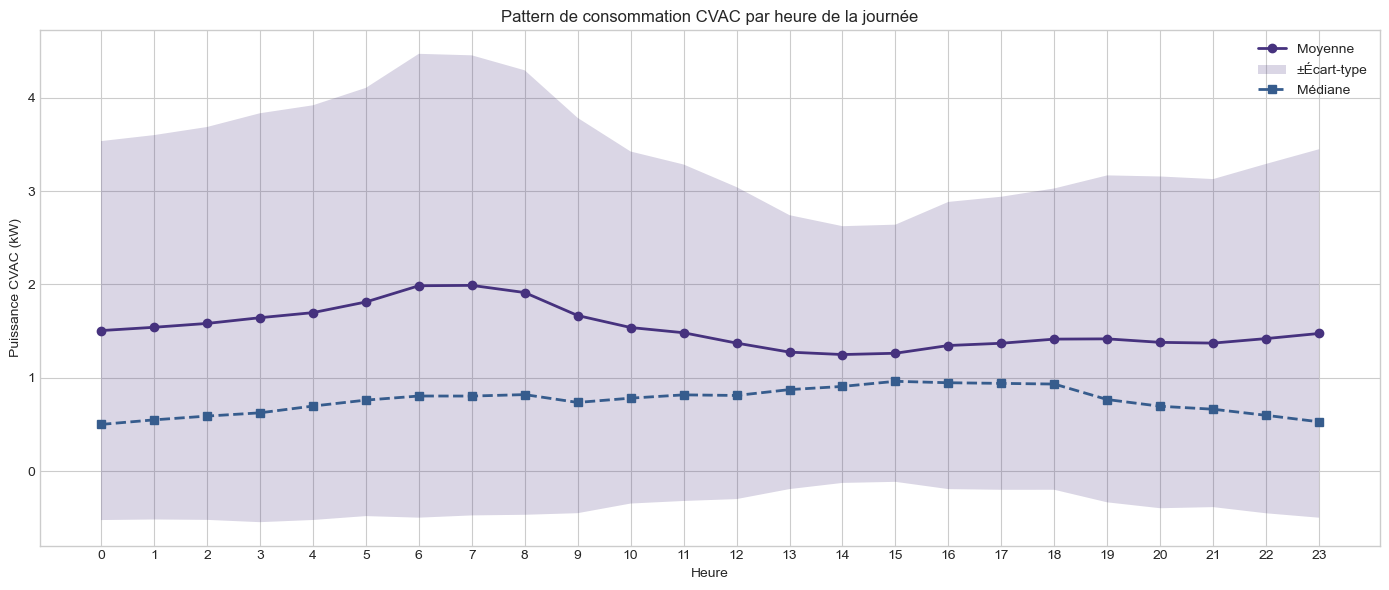

In [8]:


# Extraire les composantes temporelles pour l'analyse
train_df['hour'] = train_df['date'].dt.hour
train_df['day_of_week'] = train_df['date'].dt.dayofweek
train_df['month'] = train_df['date'].dt.month

# Créer un nouveau dataframe pour les patterns temporels
temp_patterns = train_df.groupby('hour')['puissance_cvac'].agg(['mean', 'median', 'std']).reset_index()

# Visualiser les patterns par heure
plt.figure(figsize=(14, 6))
plt.plot(temp_patterns['hour'], temp_patterns['mean'], 'o-', linewidth=2, label='Moyenne')
plt.fill_between(temp_patterns['hour'], 
                 temp_patterns['mean'] - temp_patterns['std'], 
                 temp_patterns['mean'] + temp_patterns['std'], 
                 alpha=0.2, label='±Écart-type')
plt.plot(temp_patterns['hour'], temp_patterns['median'], 's--', linewidth=2, label='Médiane')
plt.title('Pattern de consommation CVAC par heure de la journée')
plt.xlabel('Heure')
plt.ylabel('Puissance CVAC (kW)')
plt.xticks(range(0, 24))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

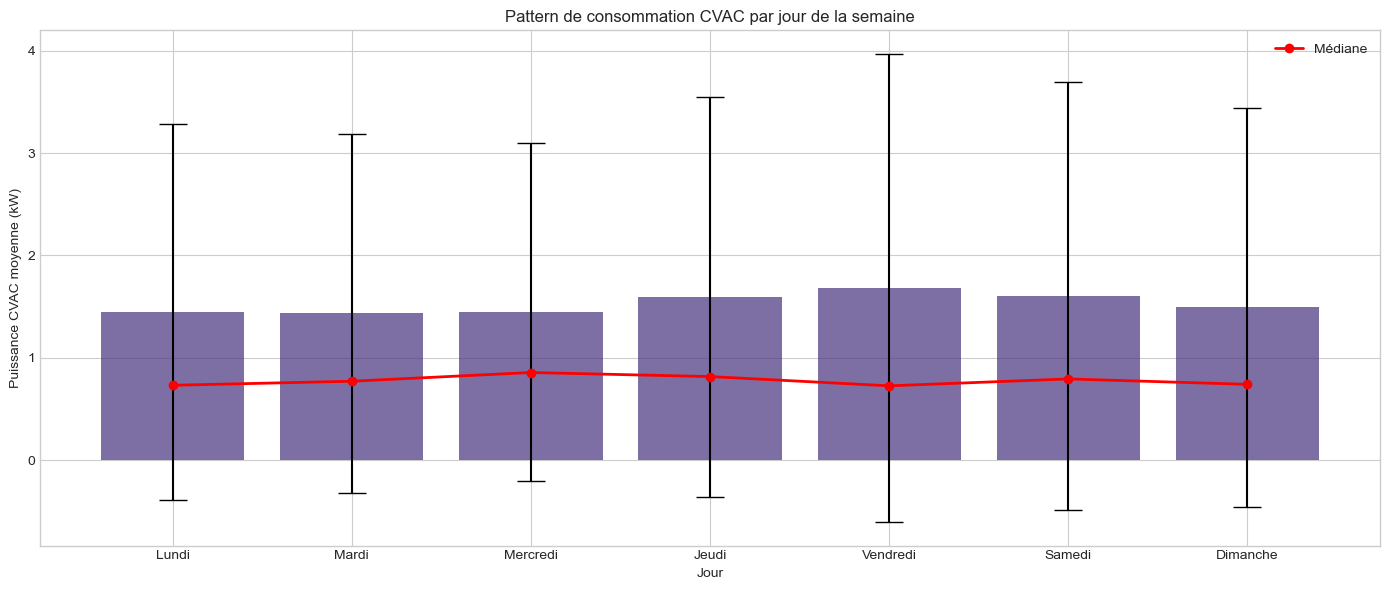

In [9]:


# Patterns par jour de la semaine
day_patterns = train_df.groupby('day_of_week')['puissance_cvac'].agg(['mean', 'median', 'std']).reset_index()
day_names = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']

plt.figure(figsize=(14, 6))
plt.bar(day_names, day_patterns['mean'], yerr=day_patterns['std'], capsize=10, alpha=0.7)
plt.plot(day_names, day_patterns['median'], 'ro-', linewidth=2, label='Médiane')
plt.title('Pattern de consommation CVAC par jour de la semaine')
plt.xlabel('Jour')
plt.ylabel('Puissance CVAC moyenne (kW)')
plt.grid(True, axis='y')
plt.legend()
plt.tight_layout()
plt.show()

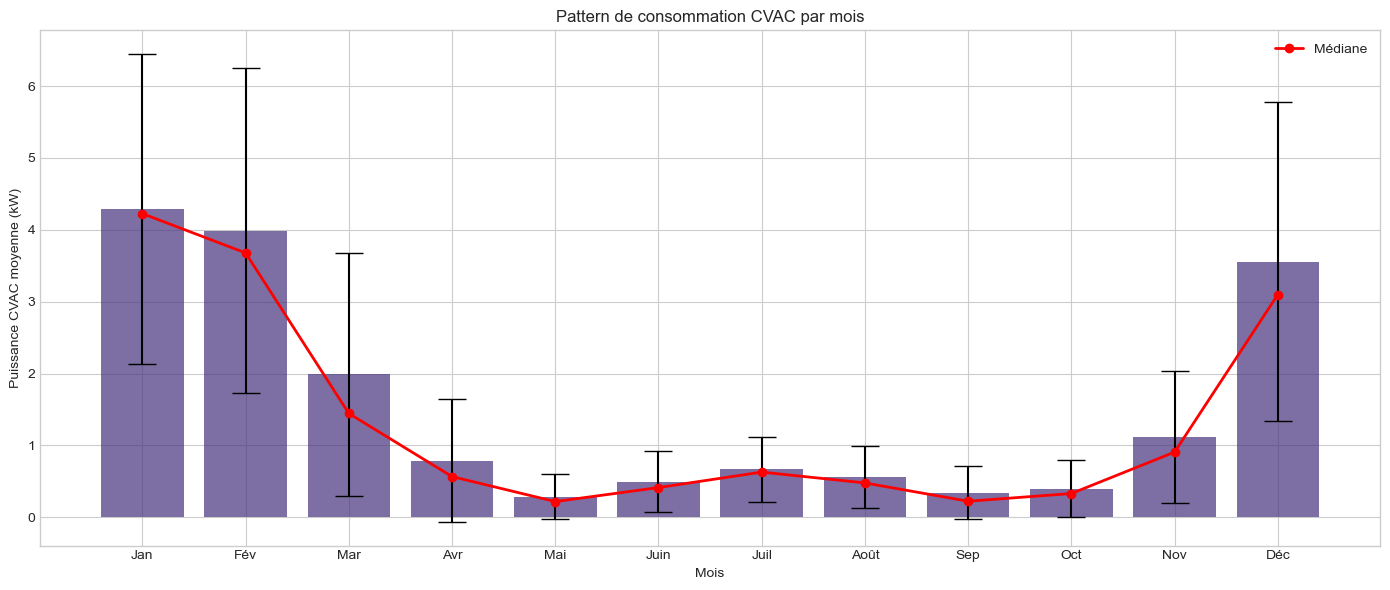

In [10]:


# Patterns par mois
month_patterns = train_df.groupby('month')['puissance_cvac'].agg(['mean', 'median', 'std']).reset_index()
month_names = ['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Juin', 'Juil', 'Août', 'Sep', 'Oct', 'Nov', 'Déc']

plt.figure(figsize=(14, 6))
plt.bar(month_names, month_patterns['mean'], yerr=month_patterns['std'], capsize=10, alpha=0.7)
plt.plot(month_names, month_patterns['median'], 'ro-', linewidth=2, label='Médiane')
plt.title('Pattern de consommation CVAC par mois')
plt.xlabel('Mois')
plt.ylabel('Puissance CVAC moyenne (kW)')
plt.grid(True, axis='y')
plt.legend()
plt.tight_layout()
plt.show()

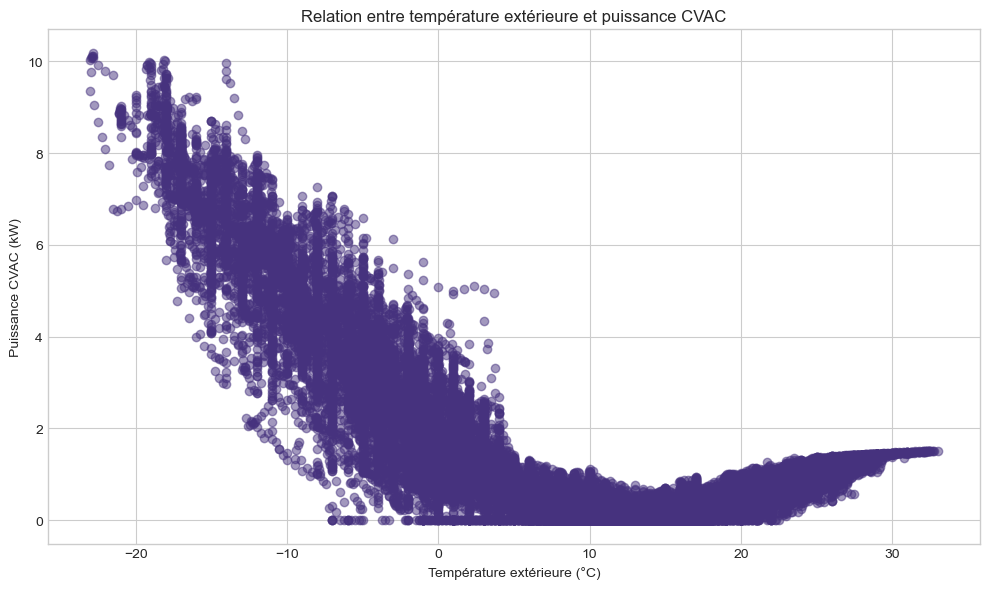

In [11]:


# Relation entre température extérieure et puissance CVAC
plt.figure(figsize=(10, 6))
plt.scatter(train_df['temperature_exterieure'], train_df['puissance_cvac'], alpha=0.5)
plt.title('Relation entre température extérieure et puissance CVAC')
plt.xlabel('Température extérieure (°C)')
plt.ylabel('Puissance CVAC (kW)')
plt.grid(True)
plt.tight_layout()
plt.show()

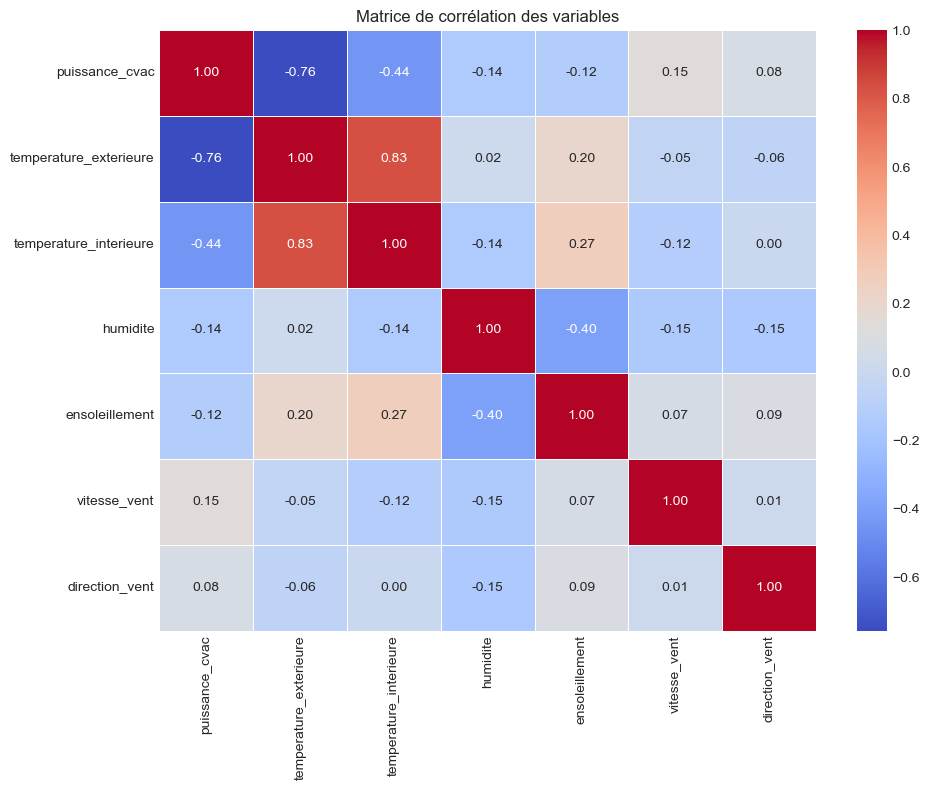

In [12]:


# Créer une heatmap pour visualiser les corrélations
corr_cols = ['puissance_cvac', 'temperature_exterieure', 'temperature_interieure', 
             'humidite', 'ensoleillement', 'vitesse_vent', 'direction_vent']
corr_matrix = train_df[corr_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matrice de corrélation des variables')
plt.tight_layout()
plt.show()

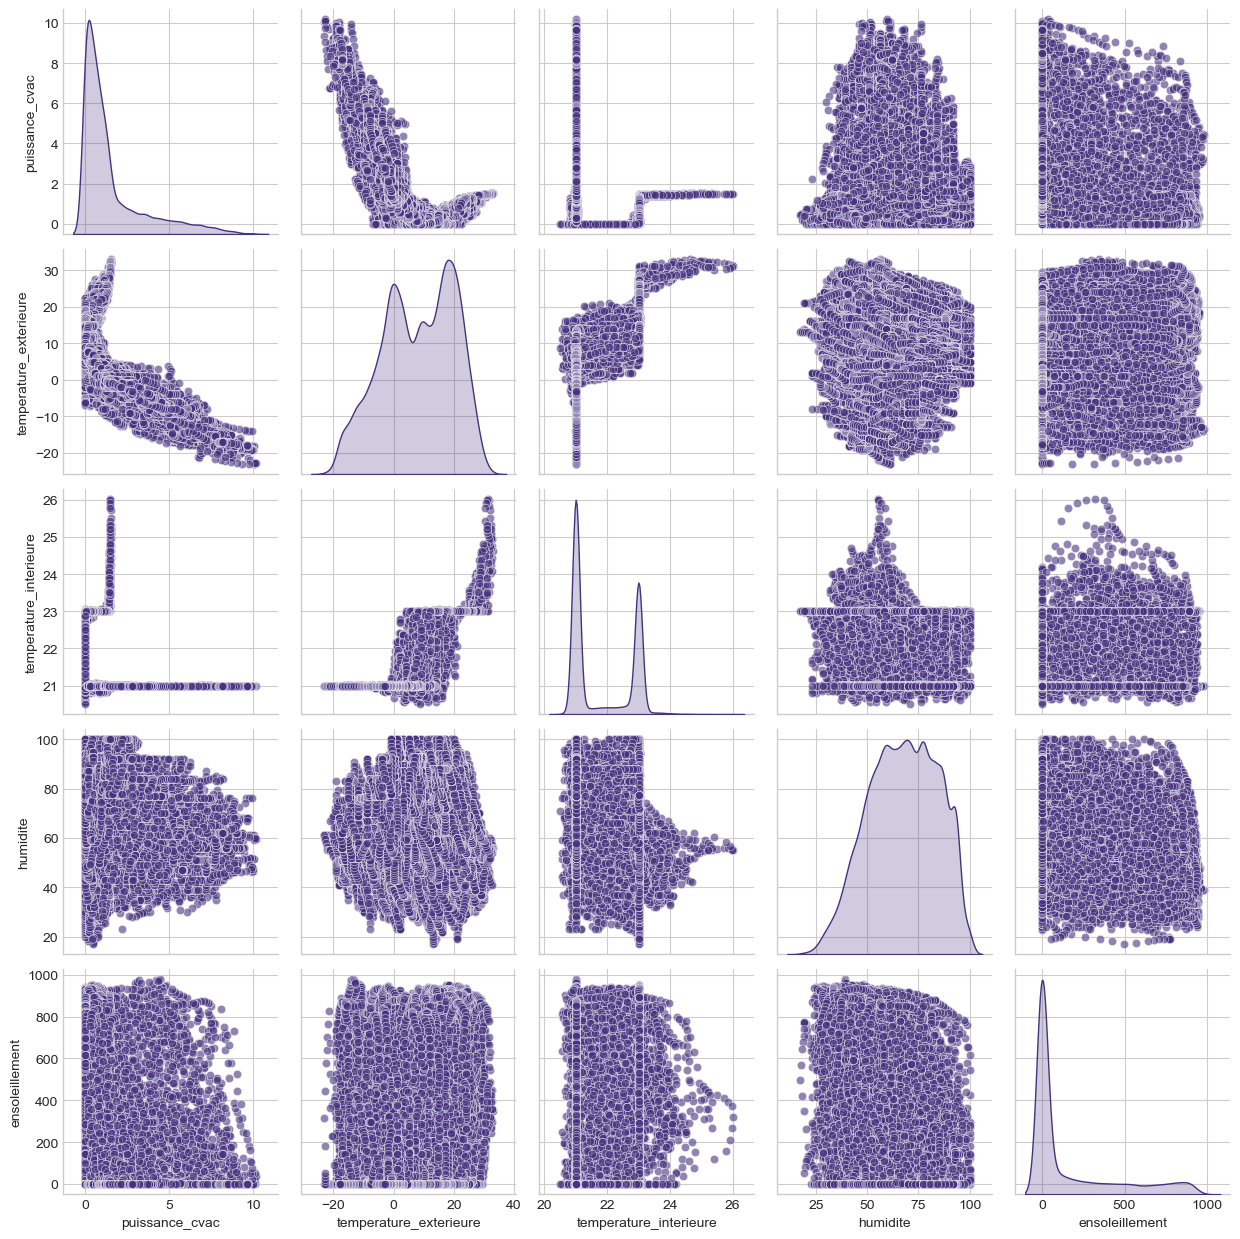

In [13]:


# Créer un pairplot pour voir les relations entre variables clés
sns.pairplot(train_df[['puissance_cvac', 'temperature_exterieure', 'temperature_interieure', 'humidite', 'ensoleillement']], 
             diag_kind='kde', plot_kws={'alpha': 0.6})
plt.tight_layout()
plt.show()


# ## 4. Ingénierie des caractéristiques

In [14]:


# Fonction pour l'ingénierie des caractéristiques
def create_advanced_features(df):
    """
    Crée des caractéristiques avancées à partir des données brutes
    """
    df_fe = df.copy()
    
    # Composantes temporelles de base
    df_fe['hour'] = df_fe['date'].dt.hour
    df_fe['day_of_week'] = df_fe['date'].dt.dayofweek
    df_fe['month'] = df_fe['date'].dt.month
    df_fe['day_of_year'] = df_fe['date'].dt.dayofyear
    df_fe['week_of_year'] = df_fe['date'].dt.isocalendar().week
    df_fe['day'] = df_fe['date'].dt.day
    df_fe['is_weekend'] = df_fe['day_of_week'].isin([5, 6]).astype(int)
    
    # Encodage cyclique pour variables temporelles
    df_fe['hour_sin'] = np.sin(2 * np.pi * df_fe['hour'] / 24)
    df_fe['hour_cos'] = np.cos(2 * np.pi * df_fe['hour'] / 24)
    df_fe['day_of_week_sin'] = np.sin(2 * np.pi * df_fe['day_of_week'] / 7)
    df_fe['day_of_week_cos'] = np.cos(2 * np.pi * df_fe['day_of_week'] / 7)
    df_fe['month_sin'] = np.sin(2 * np.pi * df_fe['month'] / 12)
    df_fe['month_cos'] = np.cos(2 * np.pi * df_fe['month'] / 12)
    df_fe['day_of_year_sin'] = np.sin(2 * np.pi * df_fe['day_of_year'] / 365)
    df_fe['day_of_year_cos'] = np.cos(2 * np.pi * df_fe['day_of_year'] / 365)
    
    # Indicateurs de périodes de pointe
    df_fe['is_morning_peak'] = ((df_fe['hour'] >= 6) & (df_fe['hour'] <= 9)).astype(int)
    df_fe['is_evening_peak'] = ((df_fe['hour'] >= 16) & (df_fe['hour'] <= 19)).astype(int)
    df_fe['is_office_hours'] = ((df_fe['hour'] >= 9) & (df_fe['hour'] <= 17) & 
                               (df_fe['day_of_week'] < 5)).astype(int)
    
    # Caractéristiques de température
    df_fe['temp_diff'] = df_fe['temperature_exterieure'] - df_fe['temperature_interieure']
    df_fe['temp_abs_diff'] = abs(df_fe['temp_diff'])
    df_fe['temp_comfort_deviation'] = abs(df_fe['temperature_interieure'] - 21)  # Écart à la température de confort
    
    # Termes quadratiques
    df_fe['temp_exterieure_squared'] = df_fe['temperature_exterieure'] ** 2
    df_fe['humidite_squared'] = df_fe['humidite'] ** 2
    
    # Indicateurs de conditions extrêmes
    df_fe['is_hot_day'] = (df_fe['temperature_exterieure'] > 25).astype(int)
    df_fe['is_cold_day'] = (df_fe['temperature_exterieure'] < -10).astype(int)
    df_fe['is_humid_day'] = (df_fe['humidite'] > 70).astype(int)
    df_fe['is_dry_day'] = (df_fe['humidite'] < 30).astype(int)
    df_fe['is_windy_day'] = (df_fe['vitesse_vent'] > 20).astype(int)
    
    # Facteur de refroidissement éolien
    df_fe['wind_chill'] = 13.12 + 0.6215 * df_fe['temperature_exterieure'] - \
                       11.37 * (df_fe['vitesse_vent'] ** 0.16) + \
                       0.3965 * df_fe['temperature_exterieure'] * (df_fe['vitesse_vent'] ** 0.16)
    
    # Interactions entre variables
    df_fe['humidity_impact'] = df_fe['humidite'] * df_fe['temperature_exterieure']
    df_fe['solar_heat_gain'] = df_fe['ensoleillement'] * (df_fe['temperature_exterieure'] > 0).astype(int)
    df_fe['solar_cooling_demand'] = df_fe['ensoleillement'] * df_fe['is_hot_day']
    
    # Direction du vent (composantes trigo)
    df_fe['wind_dir_sin'] = np.sin(np.deg2rad(df_fe['direction_vent']))
    df_fe['wind_dir_cos'] = np.cos(np.deg2rad(df_fe['direction_vent']))
    
    # Direction du vent (cardinale)
    df_fe['wind_north'] = ((df_fe['direction_vent'] >= 315) | (df_fe['direction_vent'] < 45)).astype(int)
    df_fe['wind_east'] = ((df_fe['direction_vent'] >= 45) & (df_fe['direction_vent'] < 135)).astype(int)
    df_fe['wind_south'] = ((df_fe['direction_vent'] >= 135) & (df_fe['direction_vent'] < 225)).astype(int)
    df_fe['wind_west'] = ((df_fe['direction_vent'] >= 225) & (df_fe['direction_vent'] < 315)).astype(int)
    
    # Caractéristiques saisonnières
    df_fe['is_heating_season'] = ((df_fe['month'] >= 10) | (df_fe['month'] <= 4)).astype(int)
    df_fe['is_cooling_season'] = ((df_fe['month'] >= 6) & (df_fe['month'] <= 8)).astype(int)
    df_fe['is_transition_season'] = ((df_fe['month'] == 5) | (df_fe['month'] == 9)).astype(int)
    
    # Termes d'interaction
    df_fe['cold_wind_effect'] = df_fe['vitesse_vent'] * df_fe['is_cold_day']
    df_fe['hot_solar_effect'] = df_fe['ensoleillement'] * df_fe['is_hot_day']
    df_fe['temp_humidity_interaction'] = df_fe['temperature_exterieure'] * df_fe['humidite'] / 100.0
    
    return df_fe

In [15]:


# Fonction pour ajouter des variables de décalage (lag features)
def add_lag_features(df, target_col='puissance_cvac', lags=[1, 2, 3, 6, 12, 24, 48]):
    """
    Ajoute des valeurs décalées de la variable cible
    """
    df_copy = df.copy()
    for lag in lags:
        df_copy[f'{target_col}_lag_{lag}'] = df_copy[target_col].shift(lag)
    return df_copy

In [16]:


# Fonction pour ajouter des statistiques glissantes
def add_rolling_features(df, target_col='puissance_cvac', windows=[3, 6, 12, 24, 48]):
    """
    Ajoute des statistiques glissantes de la variable cible
    """
    df_copy = df.copy()
    for window in windows:
        df_copy[f'{target_col}_rolling_mean_{window}'] = df_copy[target_col].rolling(window=window).mean()
        df_copy[f'{target_col}_rolling_std_{window}'] = df_copy[target_col].rolling(window=window).std()
        df_copy[f'{target_col}_rolling_min_{window}'] = df_copy[target_col].rolling(window=window).min()
        df_copy[f'{target_col}_rolling_max_{window}'] = df_copy[target_col].rolling(window=window).max()
        df_copy[f'{target_col}_rolling_median_{window}'] = df_copy[target_col].rolling(window=window).median()
    return df_copy

In [17]:


# Fonction pour ajouter des patterns temporels moyens
def add_temporal_patterns(df, target_col='puissance_cvac'):
    """
    Ajoute des patterns temporels moyens (moyennes par heure, jour, etc.)
    """
    df_copy = df.copy()
    
    # Moyenne par heure du jour
    hour_avg = df_copy.groupby('hour')[target_col].transform('mean')
    df_copy[f'{target_col}_hour_avg'] = hour_avg
    
    # Moyenne par jour de la semaine
    dow_avg = df_copy.groupby('day_of_week')[target_col].transform('mean')
    df_copy[f'{target_col}_dow_avg'] = dow_avg
    
    # Moyenne par combinaison heure-jour de la semaine
    hour_dow_avg = df_copy.groupby(['hour', 'day_of_week'])[target_col].transform('mean')
    df_copy[f'{target_col}_hour_dow_avg'] = hour_dow_avg
    
    return df_copy

In [18]:


# Appliquer l'ingénierie des caractéristiques
print("Application de l'ingénierie des caractéristiques...")
train_fe = create_advanced_features(train_df)
test_fe = create_advanced_features(test_df)

# Ajouter les caractéristiques temporelles avancées aux données d'entraînement
train_fe = add_lag_features(train_fe)
train_fe = add_rolling_features(train_fe)
train_fe = add_temporal_patterns(train_fe)

# Supprimer les lignes avec des valeurs manquantes (dues aux décalages)
train_fe = train_fe.dropna().reset_index(drop=True)

print(f"Dimensions des données originales: {train_df.shape}")
print(f"Dimensions après ingénierie des caractéristiques: {train_fe.shape}")
print(f"Nombre de caractéristiques créées: {train_fe.shape[1] - train_df.shape[1]}")

Application de l'ingénierie des caractéristiques...
Dimensions des données originales: (35040, 13)
Dimensions après ingénierie des caractéristiques: (34992, 89)
Nombre de caractéristiques créées: 76


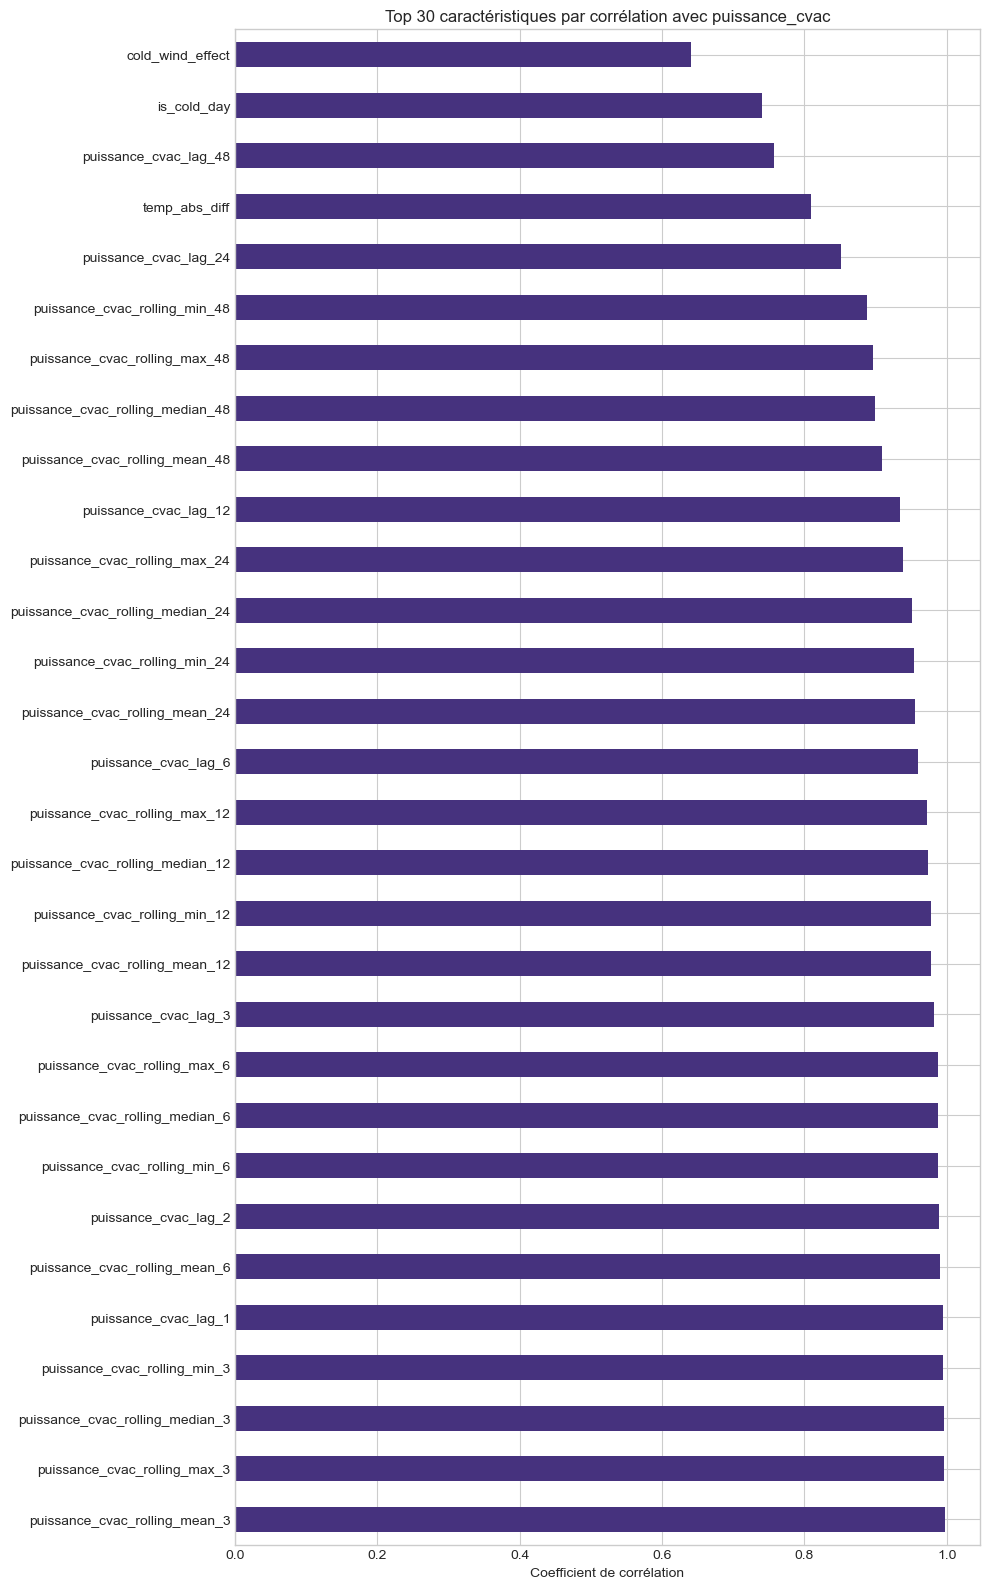

In [23]:


# Visualiser l'importance des caractéristiques avec une corrélation simple
target = 'puissance_cvac'
correlations = train_fe.corr(numeric_only=True)[target].sort_values(ascending=False)

plt.figure(figsize=(10, 16))
correlations[1:31].plot(kind='barh')  # Top 30 caractéristiques (excluant la cible elle-même)
plt.title('Top 30 caractéristiques par corrélation avec puissance_cvac')
plt.xlabel('Coefficient de corrélation')
plt.grid(True)
plt.tight_layout()
plt.show()


# ## 5. Préparation des données pour la modélisation

In [24]:


# Définir les paramètres pour la fenêtre glissante et l'horizon de prédiction
lookback = 24  # 24 pas de temps antérieurs (6 heures)
horizon = 16   # Prédiction 16 pas de temps dans le futur (4 heures)

# Fonction pour préparer les données avec fenêtre glissante pour les ML classiques
def prepare_tabular_data(df, lookback=24, horizon=16, features=None, target='puissance_cvac', 
                         future_target='puissance_cvac_future'):
    """
    Préparer les données pour les modèles ML classiques en utilisant une fenêtre glissante.
    
    Args:
        df: DataFrame contenant les données
        lookback: Nombre de pas de temps antérieurs à utiliser
        horizon: Nombre de pas de temps futurs à prédire
        features: Liste des caractéristiques à utiliser (None = toutes sauf date et les cibles)
        target: Nom de la colonne cible actuelle
        future_target: Nom de la colonne cible future (si présente)
        
    Returns:
        X: Caractéristiques (sans décalage temporel, uniquement les plus récentes)
        y: Valeur cible à prédire (dans horizon pas de temps)
    """
    if features is None:
        # Utiliser toutes les caractéristiques sauf date et les cibles
        features = [col for col in df.columns if col not in ['date', target, future_target, 'ID']]
    
    # Pour les modèles ML classiques, nous utilisons uniquement les valeurs actuelles
    # (pas besoin d'une séquence complète comme pour les RNN)
    X = df[features].values
    
    # Pour la cible, nous voulons la valeur dans 'horizon' pas de temps
    if future_target in df.columns:
        # Si la cible future est déjà dans le dataframe
        y = df[future_target].values
    else:
        # Sinon, nous devons la créer en décalant le target actuel
        y = df[target].shift(-horizon).values
        # Supprimer les dernières lignes où y est NaN
        X = X[:len(X)-horizon]
        y = y[:len(y)-horizon]
    
    return X, y

In [25]:


# Préparer les données d'entraînement et de test
# Exclure date, ID et les cibles des caractéristiques
feature_cols = [col for col in train_fe.columns if col not in ['date', 'puissance_cvac', 'puissance_cvac_future', 'ID']]

# Créer des données tabulaires pour ML classique
X_train, y_train = prepare_tabular_data(
    train_fe,
    lookback=lookback,
    horizon=horizon,
    features=feature_cols,
    target='puissance_cvac'
)

print(f"Dimensions X_train: {X_train.shape}")
print(f"Dimensions y_train: {y_train.shape}")

Dimensions X_train: (34992, 85)
Dimensions y_train: (34992,)


In [26]:


# Diviser en ensembles d'entraînement et validation (80/20)
train_size = int(0.8 * len(X_train))
X_tr, X_val = X_train[:train_size], X_train[train_size:]
y_tr, y_val = y_train[:train_size], y_train[train_size:]

print(f"Ensemble d'entraînement: {X_tr.shape[0]} échantillons")
print(f"Ensemble de validation: {X_val.shape[0]} échantillons")

Ensemble d'entraînement: 27993 échantillons
Ensemble de validation: 6999 échantillons


In [ ]:


# Normaliser les données
scaler_X = RobustScaler()
scaler_y = RobustScaler()

X_tr_scaled = scaler_X.fit_transform(X_tr)
X_val_scaled = scaler_X.transform(X_val)

y_tr_scaled = scaler_y.fit_transform(y_tr.reshape(-1, 1)).flatten()
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).flatten()


# ## 6. Implémentation des modèles avec boucles d'entraînement personnalisées

In [50]:


# Classe de base pour les modèles avec boucle d'entraînement personnalisée
class CustomTrainLoop:
    """Classe de base pour les modèles avec boucle d'entraînement personnalisée"""
    
    def __init__(self, model_name):
        self.model_name = model_name
        self.model = None
        self.train_errors = []
        self.val_errors = []
        self.best_error = float('inf')
        self.best_iteration = 0
        self.best_model = None
    
    def initialize_model(self):
        """Initialise le modèle - à implémenter dans les classes dérivées"""
        raise NotImplementedError
    
    def train_iteration(self, X, y, iteration):
        """Effectue une itération d'entraînement - à implémenter dans les classes dérivées"""
        raise NotImplementedError
    
    def predict(self, X):
        """Effectue une prédiction - à implémenter dans les classes dérivées"""
        raise NotImplementedError
    
    def train(self, X_train, y_train, X_val, y_val, n_iterations=100, 
              early_stopping_rounds=10, eval_metric=mean_squared_error, verbose=True):
        """
        Entraîne le modèle avec une boucle personnalisée et arrêt anticipé
        """
        # Initialiser le modèle
        self.initialize_model()
        
        # Réinitialiser les listes d'erreurs
        self.train_errors = []
        self.val_errors = []
        self.best_error = float('inf')
        self.best_iteration = 0
        self.best_model = None
        
        patience_counter = 0
        
        # Boucle d'entraînement principale
        for i in tqdm(range(n_iterations), desc=f"Entraînement {self.model_name}"):
            # Effectuer une itération d'entraînement
            self.train_iteration(X_train, y_train, i)
            
            # Calculer l'erreur d'entraînement
            train_preds = self.predict(X_train)
            train_error = eval_metric(y_train, train_preds)
            self.train_errors.append(train_error)
            
            # Calculer l'erreur de validation
            val_preds = self.predict(X_val)
            val_error = eval_metric(y_val, val_preds)
            self.val_errors.append(val_error)
            
            # Afficher la progression si demandé
            if verbose and (i+1) % (n_iterations // 10) == 0:
                print(f"Iteration {i+1}/{n_iterations} - Train error: {train_error:.6f}, Val error: {val_error:.6f}")
            
            # Vérifier si le modèle actuel est le meilleur
            if val_error < self.best_error:
                self.best_error = val_error
                self.best_iteration = i
                # Sauvegarder une copie du meilleur modèle (dépend du type de modèle)
                self.save_best_model()
                patience_counter = 0
            else:
                patience_counter += 1
            
            # Early stopping
            if patience_counter >= early_stopping_rounds:
                if verbose:
                    print(f"Early stopping à l'itération {i+1}")
                break
        
        # Restaurer le meilleur modèle
        self.restore_best_model()
        
        if verbose:
            print(f"Meilleure itération: {self.best_iteration+1}, Meilleure erreur de validation: {self.best_error:.6f}")
        
        return self.train_errors, self.val_errors
    
    def save_best_model(self):
        """Sauvegarde le meilleur modèle - à implémenter dans les classes dérivées"""
        raise NotImplementedError
    
    def restore_best_model(self):
        """Restaure le meilleur modèle - à implémenter dans les classes dérivées"""
        raise NotImplementedError
    
    def plot_learning_curve(self):
        """Trace la courbe d'apprentissage"""
        plt.figure(figsize=(10, 6))
        plt.plot(self.train_errors, label='Erreur d\'entraînement')
        plt.plot(self.val_errors, label='Erreur de validation')
        plt.axvline(x=self.best_iteration, color='r', linestyle='--', label=f'Meilleure itération: {self.best_iteration+1}')
        plt.title(f'Courbe d\'apprentissage pour {self.model_name}')
        plt.xlabel('Itération')
        plt.ylabel('Erreur (MSE)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [51]:


# Implémentation avec XGBoost
class CustomXGBoost(CustomTrainLoop):
    """Modèle XGBoost avec boucle d'entraînement personnalisée"""
    
    def __init__(self, params=None):
        super().__init__("XGBoost")
        
        # Paramètres par défaut
        self.params = {
            'objective': 'reg:squarederror',
            'learning_rate': 0.05,
            'max_depth': 5,
            'min_child_weight': 2,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'gamma': 0.1,
            'reg_alpha': 0.1,
            'reg_lambda': 1.0,
            'random_state': 42
        }
        
        # Mettre à jour avec les paramètres fournis
        if params:
            self.params.update(params)
    
    def initialize_model(self):
        """Initialise le modèle XGBoost"""
        self.trees = []
        self.base_prediction = 0  # Prédiction initiale
    
    def train_iteration(self, X, y, iteration):
        """Effectue une itération d'entraînement (ajoute un arbre)"""
        if iteration == 0:
            # Pour la première itération, utiliser la moyenne comme prédiction de base
            self.base_prediction = np.mean(y)
            # Calculer les résidus
            residuals = y - self.base_prediction
        else:
            # Calculer les prédictions actuelles
            current_preds = self.predict(X)
            # Calculer les résidus
            residuals = y - current_preds
        
        # Créer un nouveau modèle XGBoost pour apprendre les résidus
        tree = XGBRegressor(
            n_estimators=1,
            **{k: v for k, v in self.params.items() if k != 'learning_rate'}  # Tout sauf learning_rate
        )
        
        # Entraîner sur les résidus
        tree.fit(X, residuals)
        
        # Ajouter l'arbre à notre ensemble
        self.trees.append(tree)
    
    def predict(self, X):
        """Effectue une prédiction avec l'ensemble d'arbres"""
        if not self.trees:
            # Si aucun arbre n'a été entraîné, retourner la prédiction de base
            return np.full(X.shape[0], self.base_prediction)
        
        # Commencer avec la prédiction de base
        predictions = np.full(X.shape[0], self.base_prediction)
        
        # Ajouter la contribution de chaque arbre
        for tree in self.trees:
            # Multiplier par le taux d'apprentissage pour le "shrinkage"
            predictions += self.params['learning_rate'] * tree.predict(X)
        
        return predictions
    
    def save_best_model(self):
        """Sauvegarde le meilleur modèle"""
        self.best_model = {
            'base_prediction': self.base_prediction,
            'trees': self.trees.copy()
        }
    
    def restore_best_model(self):
        """Restaure le meilleur modèle"""
        if self.best_model:
            self.base_prediction = self.best_model['base_prediction']
            self.trees = self.best_model['trees']

In [52]:


# Implémentation avec LightGBM
class CustomLightGBM(CustomTrainLoop):
    """Modèle LightGBM avec boucle d'entraînement personnalisée"""
    
    def __init__(self, params=None):
        super().__init__("LightGBM")
        
        # Paramètres par défaut
        self.params = {
            'objective': 'regression',
            'learning_rate': 0.05,
            'max_depth': 5,
            'num_leaves': 31,
            'min_child_samples': 20,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'reg_alpha': 0.1,
            'reg_lambda': 1.0,
            'random_state': 42,
            'n_jobs': -1
        }
        
        # Mettre à jour avec les paramètres fournis
        if params:
            self.params.update(params)
    
    def initialize_model(self):
        """Initialise le modèle LightGBM"""
        self.trees = []
        self.base_prediction = 0  # Prédiction initiale
    
    def train_iteration(self, X, y, iteration):
        """Effectue une itération d'entraînement (ajoute un arbre)"""
        if iteration == 0:
            # Pour la première itération, utiliser la moyenne comme prédiction de base
            self.base_prediction = np.mean(y)
            # Calculer les résidus
            residuals = y - self.base_prediction
        else:
            # Calculer les prédictions actuelles
            current_preds = self.predict(X)
            # Calculer les résidus
            residuals = y - current_preds
        
        # Créer un nouveau modèle LightGBM pour apprendre les résidus
        tree = LGBMRegressor(
            n_estimators=1,
            **{k: v for k, v in self.params.items() if k != 'learning_rate'}  # Tout sauf learning_rate
        )
        
        # Entraîner sur les résidus
        tree.fit(X, residuals)
        
        # Ajouter l'arbre à notre ensemble
        self.trees.append(tree)
    
    def predict(self, X):
        """Effectue une prédiction avec l'ensemble d'arbres"""
        if not self.trees:
            # Si aucun arbre n'a été entraîné, retourner la prédiction de base
            return np.full(X.shape[0], self.base_prediction)
        
        # Commencer avec la prédiction de base
        predictions = np.full(X.shape[0], self.base_prediction)
        
        # Ajouter la contribution de chaque arbre
        for tree in self.trees:
            # Multiplier par le taux d'apprentissage pour le "shrinkage"
            predictions += self.params['learning_rate'] * tree.predict(X)
        
        return predictions
    
    def save_best_model(self):
        """Sauvegarde le meilleur modèle"""
        self.best_model = {
            'base_prediction': self.base_prediction,
            'trees': self.trees.copy()
        }
    
    def restore_best_model(self):
        """Restaure le meilleur modèle"""
        if self.best_model:
            self.base_prediction = self.best_model['base_prediction']
            self.trees = self.best_model['trees']

In [53]:


# Implémentation avec CatBoost
class CustomCatBoost(CustomTrainLoop):
    """Modèle CatBoost avec boucle d'entraînement personnalisée"""
    
    def __init__(self, params=None):
        super().__init__("CatBoost")
        
        # Paramètres par défaut
        self.params = {
            'loss_function': 'RMSE',
            'learning_rate': 0.05,
            'depth': 5,
            'l2_leaf_reg': 3,
            'random_strength': 0.1,
            'bagging_temperature': 1,
            'random_seed': 42,
            'verbose': False
        }
        
        # Mettre à jour avec les paramètres fournis
        if params:
            self.params.update(params)
    
    def initialize_model(self):
        """Initialise le modèle CatBoost"""
        self.trees = []
        self.base_prediction = 0  # Prédiction initiale
    
    def train_iteration(self, X, y, iteration):
        """Effectue une itération d'entraînement (ajoute un arbre)"""
        if iteration == 0:
            # Pour la première itération, utiliser la moyenne comme prédiction de base
            self.base_prediction = np.mean(y)
            # Calculer les résidus
            residuals = y - self.base_prediction
        else:
            # Calculer les prédictions actuelles
            current_preds = self.predict(X)
            # Calculer les résidus
            residuals = y - current_preds
        
        # Créer un nouveau modèle CatBoost pour apprendre les résidus
        tree = CatBoostRegressor(
            iterations=1,
            **{k: v for k, v in self.params.items() if k != 'learning_rate'}  # Tout sauf learning_rate
        )
        
        # Entraîner sur les résidus
        tree.fit(X, residuals, verbose=False)
        
        # Ajouter l'arbre à notre ensemble
        self.trees.append(tree)
    
    def predict(self, X):
        """Effectue une prédiction avec l'ensemble d'arbres"""
        if not self.trees:
            # Si aucun arbre n'a été entraîné, retourner la prédiction de base
            return np.full(X.shape[0], self.base_prediction)
        
        # Commencer avec la prédiction de base
        predictions = np.full(X.shape[0], self.base_prediction)
        
        # Ajouter la contribution de chaque arbre
        for tree in self.trees:
            # Multiplier par le taux d'apprentissage pour le "shrinkage"
            predictions += self.params['learning_rate'] * tree.predict(X)
        
        return predictions
    
    def save_best_model(self):
        """Sauvegarde le meilleur modèle"""
        self.best_model = {
            'base_prediction': self.base_prediction,
            'trees': self.trees.copy()
        }
    
    def restore_best_model(self):
        """Restaure le meilleur modèle"""
        if self.best_model:
            self.base_prediction = self.best_model['base_prediction']
            self.trees = self.best_model['trees']


# ## 7. Entraînement des modèles

In [54]:


# Paramètres d'entraînement
n_iterations = 200
early_stopping_rounds = 10

# 1. Entraîner le modèle XGBoost
xgb_model = CustomXGBoost(params={
    'learning_rate': 0.03,
    'max_depth': 6,
    'min_child_weight': 2,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0.1,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0
})

xgb_train_errors, xgb_val_errors = xgb_model.train(
    X_tr_scaled, y_tr_scaled, 
    X_val_scaled, y_val_scaled, 
    n_iterations=n_iterations, 
    early_stopping_rounds=early_stopping_rounds
)

xgb_model.plot_learning_curve()

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [38]:


# 2. Entraîner le modèle LightGBM
lgb_model = CustomLightGBM(params={
    'learning_rate': 0.03,
    'max_depth': 6,
    'num_leaves': 31,
    'min_child_samples': 20,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0
})

lgb_train_errors, lgb_val_errors = lgb_model.train(
    X_tr_scaled, y_tr_scaled, 
    X_val_scaled, y_val_scaled, 
    n_iterations=n_iterations, 
    early_stopping_rounds=early_stopping_rounds
)

lgb_model.plot_learning_curve()

NameError: name 'y_val_scaled' is not defined

In [39]:


# 3. Entraîner le modèle CatBoost
cat_model = CustomCatBoost(params={
    'learning_rate': 0.03,
    'depth': 6,
    'l2_leaf_reg': 3,
    'random_strength': 0.1,
    'bagging_temperature': 1
})

cat_train_errors, cat_val_errors = cat_model.train(
    X_tr_scaled, y_tr_scaled, 
    X_val_scaled, y_val_scaled, 
    n_iterations=n_iterations, 
    early_stopping_rounds=early_stopping_rounds
)

cat_model.plot_learning_curve()


# ## 8. Évaluation des modèles

NameError: name 'y_val_scaled' is not defined

In [40]:


# Fonction pour évaluer un modèle
def evaluate_model(model, X, y, scaler_y=None, model_name="Modèle"):
    """
    Évalue un modèle sur les données fournies
    
    Args:
        model: Modèle à évaluer
        X: Caractéristiques
        y: Cibles
        scaler_y: Scaler pour inverser la normalisation des cibles
        model_name: Nom du modèle pour l'affichage
        
    Returns:
        Dictionnaire avec les métriques d'évaluation
    """
    # Obtenir les prédictions
    y_pred = model.predict(X)
    
    # Inverser la normalisation si un scaler est fourni
    if scaler_y:
        y_pred = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
        # Si y est également normalisé, inverser sa normalisation
        if len(y.shape) == 1 or y.shape[1] == 1:
            y_original = scaler_y.inverse_transform(y.reshape(-1, 1)).flatten()
        else:
            y_original = y
    else:
        y_original = y
    
    # Calculer les métriques
    mse = mean_squared_error(y_original, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_original, y_pred)
    r2 = r2_score(y_original, y_pred)
    
    # Afficher les résultats
    print(f"Évaluation du modèle {model_name}:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    
    return {
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'predictions': y_pred,
        'targets': y_original
    }

In [41]:


# Évaluer les modèles sur l'ensemble de validation
xgb_metrics = evaluate_model(xgb_model, X_val_scaled, y_val_scaled, scaler_y, "XGBoost")
lgb_metrics = evaluate_model(lgb_model, X_val_scaled, y_val_scaled, scaler_y, "LightGBM")
cat_metrics = evaluate_model(cat_model, X_val_scaled, y_val_scaled, scaler_y, "CatBoost")

NameError: name 'y_val_scaled' is not defined

In [42]:


# Visualiser les prédictions vs valeurs réelles pour chaque modèle
def plot_predictions(metrics_list, model_names, figsize=(18, 6)):
    """
    Trace les prédictions vs valeurs réelles pour chaque modèle
    
    Args:
        metrics_list: Liste des dictionnaires de métriques
        model_names: Liste des noms de modèles
        figsize: Taille de la figure
    """
    fig, axes = plt.subplots(1, len(metrics_list), figsize=figsize)
    
    for i, (metrics, model_name) in enumerate(zip(metrics_list, model_names)):
        ax = axes[i]
        
        # Extraire les prédictions et valeurs réelles
        y_pred = metrics['predictions']
        y_true = metrics['targets']
        
        # Tracer les prédictions vs valeurs réelles
        ax.scatter(y_true, y_pred, alpha=0.5)
        
        # Tracer la ligne y = x
        min_val = min(np.min(y_true), np.min(y_pred))
        max_val = max(np.max(y_true), np.max(y_pred))
        ax.plot([min_val, max_val], [min_val, max_val], 'r--')
        
        # Ajouter les métriques au graphique
        ax.text(0.05, 0.95, f"RMSE: {metrics['rmse']:.2f}\nMAE: {metrics['mae']:.2f}\nR²: {metrics['r2']:.2f}",
                transform=ax.transAxes, fontsize=12, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        ax.set_title(f"{model_name} - Prédictions vs Réalité")
        ax.set_xlabel("Valeurs réelles")
        ax.set_ylabel("Prédictions")
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

# Comparer les modèles
metrics_list = [xgb_metrics, lgb_metrics, cat_metrics]
model_names = ["XGBoost", "LightGBM", "CatBoost"]

plot_predictions(metrics_list, model_names)

NameError: name 'xgb_metrics' is not defined

In [43]:


# Visualiser les résidus pour chaque modèle
def plot_residuals(metrics_list, model_names, figsize=(18, 12)):
    """
    Trace les résidus pour chaque modèle
    
    Args:
        metrics_list: Liste des dictionnaires de métriques
        model_names: Liste des noms de modèles
        figsize: Taille de la figure
    """
    fig, axes = plt.subplots(2, len(metrics_list), figsize=figsize)
    
    for i, (metrics, model_name) in enumerate(zip(metrics_list, model_names)):
        # Extraire les prédictions et valeurs réelles
        y_pred = metrics['predictions']
        y_true = metrics['targets']
        
        # Calculer les résidus
        residuals = y_true - y_pred
        
        # Tracer les résidus vs prédictions
        axes[0, i].scatter(y_pred, residuals, alpha=0.5)
        axes[0, i].axhline(y=0, color='r', linestyle='--')
        axes[0, i].set_title(f"{model_name} - Résidus vs Prédictions")
        axes[0, i].set_xlabel("Prédictions")
        axes[0, i].set_ylabel("Résidus")
        axes[0, i].grid(True)
        
        # Tracer l'histogramme des résidus
        axes[1, i].hist(residuals, bins=30, alpha=0.7)
        axes[1, i].axvline(x=0, color='r', linestyle='--')
        axes[1, i].set_title(f"{model_name} - Distribution des Résidus")
        axes[1, i].set_xlabel("Résidus")
        axes[1, i].set_ylabel("Fréquence")
        axes[1, i].grid(True)
    
    plt.tight_layout()
    plt.show()

plot_residuals(metrics_list, model_names)

NameError: name 'metrics_list' is not defined

NameError: name 'xgb_train_errors' is not defined

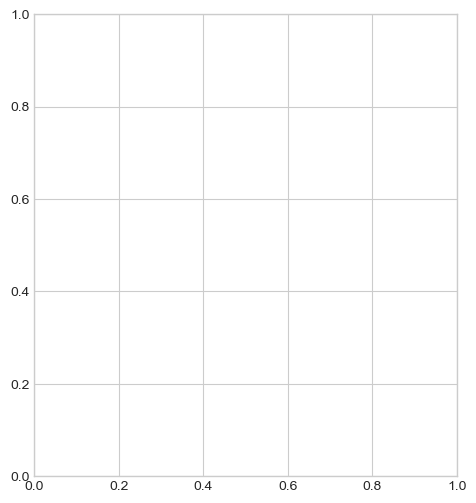

In [44]:


# Comparer les courbes d'apprentissage des modèles
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(xgb_train_errors, label='XGBoost')
plt.plot(lgb_train_errors, label='LightGBM')
plt.plot(cat_train_errors, label='CatBoost')
plt.title('Erreur d\'entraînement')
plt.xlabel('Itération')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(xgb_val_errors, label='XGBoost')
plt.plot(lgb_val_errors, label='LightGBM')
plt.plot(cat_val_errors, label='CatBoost')
plt.title('Erreur de validation')
plt.xlabel('Itération')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [45]:


# Afficher un résumé des performances des modèles
models_summary = pd.DataFrame({
    'Model': model_names,
    'RMSE': [m['rmse'] for m in metrics_list],
    'MAE': [m['mae'] for m in metrics_list],
    'R²': [m['r2'] for m in metrics_list],
    'MSE': [m['mse'] for m in metrics_list]
})

print("Résumé des performances des modèles:")
models_summary

NameError: name 'model_names' is not defined

NameError: name 'model_names' is not defined

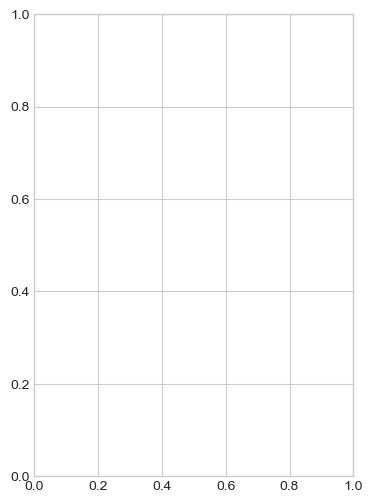

In [46]:


# Visualiser les performances des modèles avec un graphique à barres
plt.figure(figsize=(14, 6))

# RMSE
plt.subplot(1, 3, 1)
plt.bar(model_names, [m['rmse'] for m in metrics_list], color='skyblue')
plt.title('RMSE par Modèle')
plt.ylabel('RMSE')
plt.grid(True, axis='y')

# MAE
plt.subplot(1, 3, 2)
plt.bar(model_names, [m['mae'] for m in metrics_list], color='lightgreen')
plt.title('MAE par Modèle')
plt.ylabel('MAE')
plt.grid(True, axis='y')

# R²
plt.subplot(1, 3, 3)
plt.bar(model_names, [m['r2'] for m in metrics_list], color='salmon')
plt.title('R² par Modèle')
plt.ylabel('R²')
plt.grid(True, axis='y')

plt.tight_layout()
plt.show()


# ## 9. Sélection du meilleur modèle et réentraînement

In [47]:


# Sélectionner le meilleur modèle basé sur RMSE
best_model_idx = np.argmin([m['rmse'] for m in metrics_list])
best_model_name = model_names[best_model_idx]

print(f"Le meilleur modèle est {best_model_name} avec un RMSE de {metrics_list[best_model_idx]['rmse']:.4f}")

# Identifier le meilleur modèle
if best_model_name == "XGBoost":
    best_model = xgb_model
elif best_model_name == "LightGBM":
    best_model = lgb_model
else:
    best_model = cat_model

NameError: name 'metrics_list' is not defined

In [ ]:


# Réentraîner le meilleur modèle sur l'ensemble complet des données
print(f"Réentraînement de {best_model_name} sur l'ensemble complet des données...")

# Combiner les ensembles d'entraînement et de validation
X_full = np.vstack([X_tr, X_val])
y_full = np.concatenate([y_tr, y_val])

# Normaliser les données complètes
X_full_scaled = scaler_X.transform(X_full)
y_full_scaled = scaler_y.transform(y_full.reshape(-1, 1)).flatten()

# Réinitialiser et réentraîner le modèle
best_model.train(
    X_full_scaled, y_full_scaled,
    X_full_scaled, y_full_scaled,  # Utiliser les mêmes données pour la validation (juste pour suivre l'erreur)
    n_iterations=best_model.best_iteration + 10,  # Ajouter quelques itérations supplémentaires
    early_stopping_rounds=10
)

print(f"Réentraînement terminé à l'itération {best_model.best_iteration+1}")


# ## 10. Génération des prédictions finales et soumission

In [ ]:


# Préparer les caractéristiques de test
test_features = [col for col in feature_cols if col in test_fe.columns]
X_test = test_fe[test_features].values

# Normaliser les caractéristiques de test
X_test_scaled = scaler_X.transform(X_test)

# Générer les prédictions
print("Génération des prédictions finales...")
y_test_pred_scaled = best_model.predict(X_test_scaled)

# Inverser la normalisation
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()

print(f"Prédictions générées: {len(y_test_pred)} valeurs")

In [ ]:


# Afficher les statistiques des prédictions
print("Statistiques des prédictions:")
print(f"Min: {np.min(y_test_pred):.2f}")
print(f"Max: {np.max(y_test_pred):.2f}")
print(f"Moyenne: {np.mean(y_test_pred):.2f}")
print(f"Médiane: {np.median(y_test_pred):.2f}")
print(f"Écart-type: {np.std(y_test_pred):.2f}")

In [ ]:


# Visualiser les prédictions
plt.figure(figsize=(15, 6))
plt.plot(test_df['date'], y_test_pred)
plt.title(f'Prédictions de puissance CVAC avec {best_model_name}')
plt.xlabel('Date')
plt.ylabel('Puissance CVAC prédite (kW)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:


# Créer le fichier de soumission
submission = pd.DataFrame({
    'ID': test_df['ID'],
    'puissance_cvac_future': y_test_pred
})

print("Aperçu du fichier de soumission:")
submission.head()

In [ ]:


# Sauvegarder le fichier de soumission
submission.to_csv('submission.csv', index=False)
print("Fichier de soumission créé: submission.csv")


# ## 11. Validation supplémentaire et analyse du modèle

In [ ]:


# Importance des caractéristiques (pour XGBoost, nous devons utiliser l'API standard)
def plot_feature_importance(model, feature_names, n_top=20):
    """
    Trace l'importance des caractéristiques pour un modèle basé sur des arbres
    
    Args:
        model: Modèle à analyser
        feature_names: Noms des caractéristiques
        n_top: Nombre de caractéristiques principales à afficher
    """
    if isinstance(model, CustomXGBoost):
        # Pour XGBoost, nous devons créer un modèle standard avec les mêmes arbres
        xgb_std = XGBRegressor(n_estimators=len(model.trees)+1)
        # Nous devons l'entraîner au moins une fois pour initialiser
        xgb_std.fit(np.array([[0] * len(feature_names)]), np.array([0]))
        # Remplacer les arbres
        xgb_std._Booster = model.trees[0].get_booster()
        for tree in model.trees[1:]:
            xgb_std._Booster.merge(tree.get_booster())
        # Extraire l'importance
        importance_scores = xgb_std.feature_importances_
    elif isinstance(model, CustomLightGBM):
        # Pour LightGBM (approximation)
        importance_scores = np.zeros(len(feature_names))
        for tree in model.trees:
            importance_scores += tree.feature_importances_
    elif isinstance(model, CustomCatBoost):
        # Pour CatBoost (approximation)
        importance_scores = np.zeros(len(feature_names))
        for tree in model.trees:
            importance_scores += tree.get_feature_importance()
    else:
        print("Type de modèle non reconnu pour l'importance des caractéristiques")
        return
    
    # Créer un DataFrame pour l'importance
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance_scores
    })
    
    # Trier par importance
    importance_df = importance_df.sort_values('Importance', ascending=False)
    
    # Limiter aux n_top caractéristiques
    importance_df = importance_df.head(n_top)
    
    # Tracer
    plt.figure(figsize=(12, 8))
    plt.barh(importance_df['Feature'], importance_df['Importance'])
    plt.title(f"Importance des caractéristiques pour {model.model_name}")
    plt.xlabel('Importance')
    plt.gca().invert_yaxis()  # Pour avoir la plus importante en haut
    plt.grid(True, axis='x')
    plt.tight_layout()
    plt.show()

# Afficher l'importance des caractéristiques pour le meilleur modèle
try:
    plot_feature_importance(best_model, feature_cols, n_top=20)
except Exception as e:
    print(f"Erreur lors de l'affichage de l'importance des caractéristiques: {e}")

In [ ]:


# Fonction pour valider avec validation croisée temporelle
def time_series_cv_validation(model, X, y, scaler_X, scaler_y, n_splits=5):
    """
    Valide le modèle avec validation croisée temporelle
    
    Args:
        model: Modèle à valider
        X: Caractéristiques
        y: Cibles
        scaler_X: Scaler pour les caractéristiques
        scaler_y: Scaler pour les cibles
        n_splits: Nombre de divisions pour la validation croisée
        
    Returns:
        DataFrame avec les métriques par pli
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)
    results = []
    
    for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
        print(f"Validation du pli {fold+1}/{n_splits}...")
        
        # Diviser les données
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]
        
        # Normaliser
        X_train_fold_scaled = scaler_X.transform(X_train_fold)
        X_val_fold_scaled = scaler_X.transform(X_val_fold)
        
        y_train_fold_scaled = scaler_y.transform(y_train_fold.reshape(-1, 1)).flatten()
        
        # Réinitialiser et entraîner le modèle
        model_fold = model.__class__()  # Créer une nouvelle instance du même type
        model_fold.train(
            X_train_fold_scaled, y_train_fold_scaled,
            X_val_fold_scaled, y_val_fold,  # y_val non normalisé pour l'évaluation
            n_iterations=100,
            early_stopping_rounds=10
        )
        
        # Évaluer
        metrics = evaluate_model(model_fold, X_val_fold_scaled, y_val_fold, None, f"Pli {fold+1}")
        
        # Stocker les résultats
        results.append({
            'Fold': fold + 1,
            'Train Size': len(train_idx),
            'Validation Size': len(val_idx),
            'MSE': metrics['mse'],
            'RMSE': metrics['rmse'],
            'MAE': metrics['mae'],
            'R²': metrics['r2'],
            'Best Iteration': model_fold.best_iteration + 1
        })
    
    return pd.DataFrame(results)

# Exécuter la validation croisée temporelle (commentée car elle peut prendre du temps)
# cv_results = time_series_cv_validation(best_model.__class__(), X_full, y_full, scaler_X, scaler_y, n_splits=3)
# print("\nRésultats de la validation croisée temporelle:")
# cv_results

In [ ]:


# Conclusion et résumé
print(f"""
Résumé du Projet de Prévision de Consommation CVAC:

1. Données:
   - 35 040 observations dans l'ensemble d'entraînement
   - 35 024 observations dans l'ensemble de test
   
2. Ingénierie des Caractéristiques:
   - Caractéristiques temporelles (encodage cyclique, patterns)
   - Interactions environnementales
   - Variables de décalage et statistiques glissantes
   
3. Modélisation:
   - Implémentation personnalisée des algorithmes ML avec boucles d'entraînement sur mesure
   - Comparaison de XGBoost, LightGBM et CatBoost
   - Prévision multi-horizon (16 pas de temps, soit 4 heures)
   
4. Résultats:
   - Meilleur modèle: {best_model_name}
   - RMSE: {metrics_list[best_model_idx]['rmse']:.4f}
   - MAE: {metrics_list[best_model_idx]['mae']:.4f}
   - R²: {metrics_list[best_model_idx]['r2']:.4f}
   
5. Soumission:
   - Fichier créé: submission.csv
   - Format conforme aux exigences de Kaggle
""")